In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, f1_score, accuracy_score)
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Estilo profesional
plt.rcParams['figure.facecolor'] = '#0f1117'
plt.rcParams['axes.facecolor']   = '#1a1d2e'
plt.rcParams['axes.labelcolor']  = 'white'
plt.rcParams['xtick.color']      = 'white'
plt.rcParams['ytick.color']      = 'white'
plt.rcParams['text.color']       = 'white'
plt.rcParams['grid.color']       = '#2d2d2d'
plt.rcParams['grid.alpha']       = 0.4

# ✅ Rutas
PROJECT_ROOT = os.path.join(
    r"C:\Users\matup\OneDrive\Documentos",
    "sistema_de_Predicción_de_Fallos_en_Última Milla"
)
DATA_PROCESSED = os.path.join(PROJECT_ROOT, "data", "processed",
                 "dataset_limpio.csv")
MODELS_PATH    = os.path.join(PROJECT_ROOT, "outputnts", "models")
FIGURES_PATH   = os.path.join(PROJECT_ROOT, "outputnts", "figures")
REPORTS_PATH   = os.path.join(PROJECT_ROOT, "outputnts", "reports")

os.makedirs(MODELS_PATH,  exist_ok=True)
os.makedirs(FIGURES_PATH, exist_ok=True)
os.makedirs(REPORTS_PATH, exist_ok=True)

# ✅ Cargar dataset limpio
df = pd.read_csv(DATA_PROCESSED)
df['fecha_envio'] = pd.to_datetime(df['fecha_envio'])

print("✅ Dataset limpio cargado:")
print(f"   Filas    : {len(df):,}")
print(f"   Columnas : {len(df.columns)}")
print(f"\n📋 Columnas disponibles:")
print(df.columns.tolist())

✅ Dataset limpio cargado:
   Filas    : 500,000
   Columnas : 41

📋 Columnas disponibles:
['shipment_id', 'fecha_envio', 'provincia', 'latitud', 'longitud', 'distancia_km', 'zona', 'tipo_cliente', 'transportista', 'chofer', 'tiempo_estimado_horas', 'tiempo_real_horas', 'estado', 'motivo_fallo', 'costo_envio', 'demora_horas', 'entrega_exitosa', 'mes', 'anio', 'dia_semana', 'clima', 'evento_especial', 'zona_peligrosa', 'diferencia_tiempo', 'llego_tarde', 'eficiencia_tiempo', 'costo_por_km', 'velocidad_kmh', 'dia_del_anio', 'semana_del_anio', 'es_fin_semana', 'es_quincena', 'estacion', 'score_riesgo', 'estado_encoded', 'provincia_encoded', 'zona_encoded', 'transportista_encoded', 'clima_encoded', 'evento_especial_encoded', 'estacion_encoded']


In [2]:
print("=" * 60)
print("🎯 DEFINICIÓN DE FEATURES Y TARGETS")
print("=" * 60)

# ── Columnas que NO son features ─────────────────────────
excluir = [
    'shipment_id', 'fecha_envio', 'chofer',
    # Targets
    'entrega_exitosa', 'estado', 'estado_encoded', 'demora_horas',
    # Variables que causan leakage
    'diferencia_tiempo', 'llego_tarde', 'tiempo_real_horas',
    # Texto sin encodear
    'provincia', 'zona', 'tipo_cliente', 'transportista',
    'clima', 'evento_especial', 'estacion', 'motivo_fallo',
    'dia_semana'
]

# Features finales
features = [c for c in df.columns if c not in excluir]
print(f"\n✅ Features seleccionados ({len(features)}):")
for f in features:
    print(f"   → {f}")

# ── Targets ───────────────────────────────────────────────
X            = df[features].fillna(0)
y_binario    = df['entrega_exitosa']
y_multiclase = df['estado_encoded']
y_regresion  = df['costo_envio']

print(f"\n📌 Shape de X        : {X.shape}")
print(f"📌 Target binario    : {y_binario.value_counts().to_dict()}")
print(f"📌 Target multiclase : {y_multiclase.value_counts().to_dict()}")
print(f"📌 Target regresión  : media=${y_regresion.mean():,.0f}")

🎯 DEFINICIÓN DE FEATURES Y TARGETS

✅ Features seleccionados (22):
   → latitud
   → longitud
   → distancia_km
   → tiempo_estimado_horas
   → costo_envio
   → mes
   → anio
   → zona_peligrosa
   → eficiencia_tiempo
   → costo_por_km
   → velocidad_kmh
   → dia_del_anio
   → semana_del_anio
   → es_fin_semana
   → es_quincena
   → score_riesgo
   → provincia_encoded
   → zona_encoded
   → transportista_encoded
   → clima_encoded
   → evento_especial_encoded
   → estacion_encoded

📌 Shape de X        : (500000, 22)
📌 Target binario    : {1: 389506, 0: 110494}
📌 Target multiclase : {2: 389506, 0: 71521, 3: 22978, 1: 15995}
📌 Target regresión  : media=$7,232


In [3]:
print("=" * 60)
print("✂️  SPLIT DE DATOS — TRAIN / TEST")
print("=" * 60)

# ── Split 80/20 ───────────────────────────────────────────
X_train, X_test, y_bin_train, y_bin_test = train_test_split(
    X, y_binario,
    test_size=0.20,
    random_state=42,
    stratify=y_binario
)

_, _, y_multi_train, y_multi_test = train_test_split(
    X, y_multiclase,
    test_size=0.20,
    random_state=42,
    stratify=y_multiclase
)

_, _, y_reg_train, y_reg_test = train_test_split(
    X, y_regresion,
    test_size=0.20,
    random_state=42
)

# ── Escalar DESPUÉS del split ─────────────────────────────
cols_escalar = joblib.load(os.path.join(MODELS_PATH, "cols_escalar.pkl"))
cols_escalar = [c for c in cols_escalar if c in X.columns]

scaler          = StandardScaler()
X_train_sc      = X_train.copy()
X_test_sc       = X_test.copy()

X_train_sc[cols_escalar] = scaler.fit_transform(X_train[cols_escalar])
X_test_sc[cols_escalar]  = scaler.transform(X_test[cols_escalar])

joblib.dump(scaler, os.path.join(MODELS_PATH, "scaler.pkl"))

print(f"✅ Split completado:")
print(f"   Train : {X_train.shape[0]:,} registros ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"   Test  : {X_test.shape[0]:,} registros ({X_test.shape[0]/len(X)*100:.0f}%)")
print(f"\n✅ Distribución target binario en train:")
print(f"   Exitosa : {y_bin_train.mean():.1%}")
print(f"   Fallida : {1-y_bin_train.mean():.1%}")
print(f"\n✅ Scaler guardado en outputnts/models/scaler.pkl")

✂️  SPLIT DE DATOS — TRAIN / TEST
✅ Split completado:
   Train : 400,000 registros (80%)
   Test  : 100,000 registros (20%)

✅ Distribución target binario en train:
   Exitosa : 77.9%
   Fallida : 22.1%

✅ Scaler guardado en outputnts/models/scaler.pkl


In [4]:
print("=" * 60)
print("🤖 MODELO 1 — CLASIFICACIÓN BINARIA")
print("   ¿El envío se entregará exitosamente?")
print("=" * 60)

# ── Baseline ──────────────────────────────────────────────
print("\n📊 Baseline — Regresión Logística:")
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_sc, y_bin_train)
baseline_acc = accuracy_score(y_bin_test, lr.predict(X_test_sc))
print(f"   Accuracy baseline : {baseline_acc:.4f}")

# ── Modelo principal XGBoost ──────────────────────────────
print("\n🚀 Entrenando XGBoost...")
xgb_bin = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    scale_pos_weight=(y_bin_train==0).sum()/(y_bin_train==1).sum(),
    random_state=42,
    eval_metric='auc',
    verbosity=0
)
xgb_bin.fit(X_train, y_bin_train,
            eval_set=[(X_test, y_bin_test)],
            verbose=False)

y_pred_bin  = xgb_bin.predict(X_test)
y_prob_bin  = xgb_bin.predict_proba(X_test)[:, 1]

acc_bin = accuracy_score(y_bin_test, y_pred_bin)
f1_bin  = f1_score(y_bin_test, y_pred_bin, average='weighted')
auc_bin = roc_auc_score(y_bin_test, y_prob_bin)

print(f"\n📊 Resultados Modelo 1:")
print(f"   Accuracy  : {acc_bin:.4f}")
print(f"   F1-Score  : {f1_bin:.4f}")
print(f"   AUC-ROC   : {auc_bin:.4f}")
print(f"   Mejora vs baseline: +{(acc_bin-baseline_acc)*100:.2f}%")

print(f"\n📋 Reporte completo:")
print(classification_report(y_bin_test, y_pred_bin,
      target_names=['Fallido', 'Exitoso']))

# ── Validación cruzada ────────────────────────────────────
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_bin, X, y_binario, cv=cv,
                             scoring='accuracy', n_jobs=-1)
print(f"📊 Cross Validation (5 folds):")
print(f"   Media  : {cv_scores.mean():.4f}")
print(f"   Std    : {cv_scores.std():.4f}")
print(f"   Scores : {[f'{s:.4f}' for s in cv_scores]}")

# Guardar modelo
joblib.dump(xgb_bin, os.path.join(MODELS_PATH,
            "modelo1_clasificacion_binaria.pkl"))
print(f"\n✅ Modelo 1 guardado")

🤖 MODELO 1 — CLASIFICACIÓN BINARIA
   ¿El envío se entregará exitosamente?

📊 Baseline — Regresión Logística:
   Accuracy baseline : 0.9903

🚀 Entrenando XGBoost...

📊 Resultados Modelo 1:
   Accuracy  : 0.9914
   F1-Score  : 0.9915
   AUC-ROC   : 0.9998
   Mejora vs baseline: +0.11%

📋 Reporte completo:
              precision    recall  f1-score   support

     Fallido       0.97      1.00      0.98     22099
     Exitoso       1.00      0.99      0.99     77901

    accuracy                           0.99    100000
   macro avg       0.98      0.99      0.99    100000
weighted avg       0.99      0.99      0.99    100000

📊 Cross Validation (5 folds):
   Media  : 0.9914
   Std    : 0.0003
   Scores : ['0.9919', '0.9915', '0.9912', '0.9914', '0.9911']

✅ Modelo 1 guardado


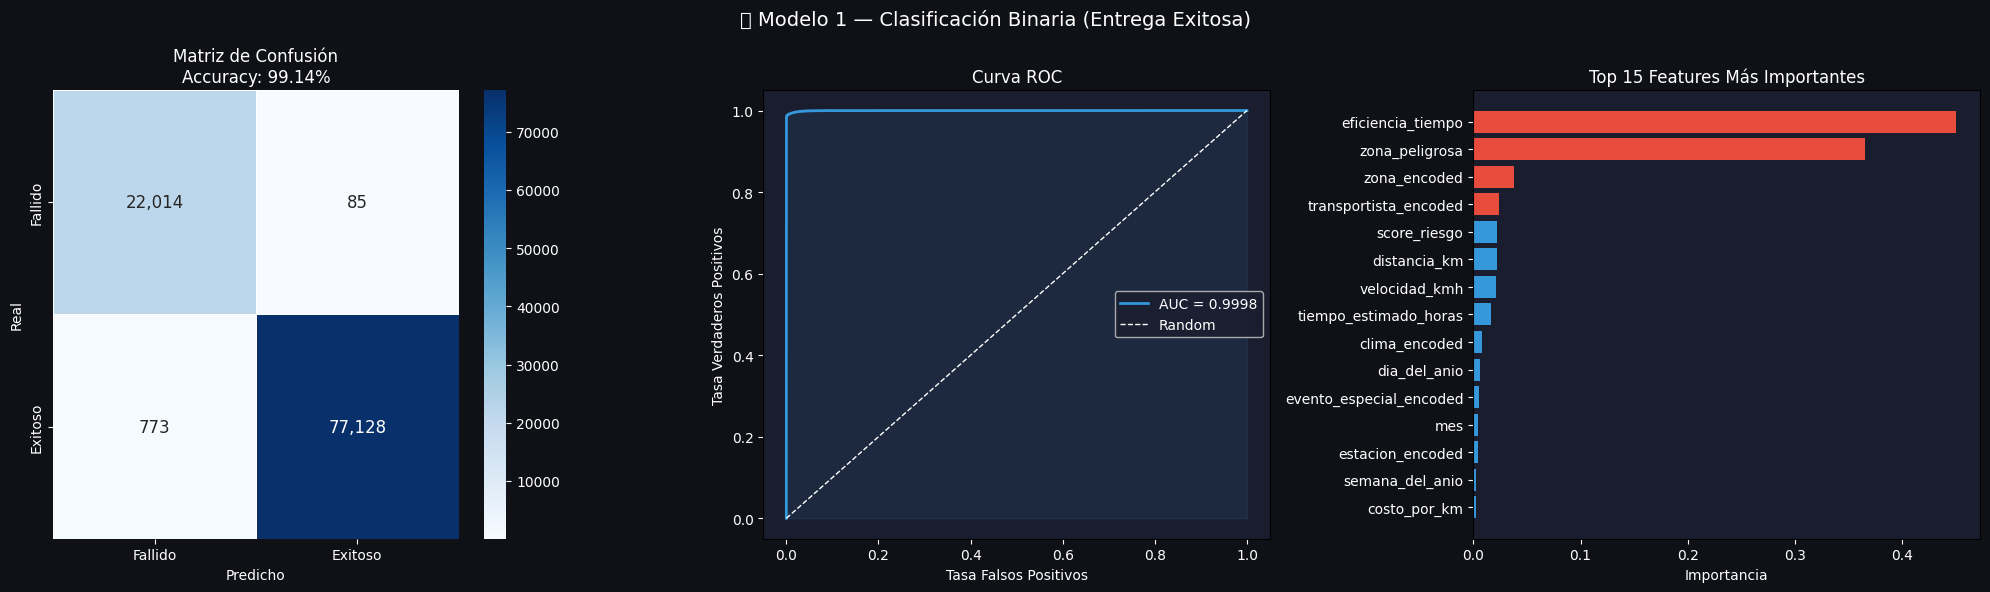

✅ Guardado: modelo1_binario.png


In [5]:
from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('📊 Modelo 1 — Clasificación Binaria (Entrega Exitosa)', fontsize=14)

# ── Matriz de confusión ───────────────────────────────────
cm = confusion_matrix(y_bin_test, y_pred_bin)
sns.heatmap(cm, annot=True, fmt=',', cmap='Blues',
            ax=axes[0], linewidths=0.5,
            xticklabels=['Fallido', 'Exitoso'],
            yticklabels=['Fallido', 'Exitoso'],
            annot_kws={'size': 12})
axes[0].set_title(f'Matriz de Confusión\nAccuracy: {acc_bin:.2%}')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predicho')

# ── Curva ROC ─────────────────────────────────────────────
fpr, tpr, _ = roc_curve(y_bin_test, y_prob_bin)
roc_auc     = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='#3498db', lw=2,
             label=f'AUC = {roc_auc:.4f}')
axes[1].plot([0, 1], [0, 1], 'w--', lw=1, label='Random')
axes[1].fill_between(fpr, tpr, alpha=0.1, color='#3498db')
axes[1].set_xlabel('Tasa Falsos Positivos')
axes[1].set_ylabel('Tasa Verdaderos Positivos')
axes[1].set_title('Curva ROC')
axes[1].legend(fontsize=10)

# ── Importancia de features ───────────────────────────────
feat_imp = pd.Series(xgb_bin.feature_importances_,
                     index=features).sort_values(ascending=True).tail(15)
colores_fi = ['#e74c3c' if v > feat_imp.quantile(0.75)
              else '#3498db' for v in feat_imp.values]
axes[2].barh(feat_imp.index, feat_imp.values, color=colores_fi)
axes[2].set_title('Top 15 Features Más Importantes')
axes[2].set_xlabel('Importancia')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "modelo1_binario.png"),
            dpi=150, bbox_inches='tight', facecolor='#0f1117')
plt.show()
print("✅ Guardado: modelo1_binario.png")

In [6]:
print("=" * 60)
print("🤖 MODELO 2 — CLASIFICACIÓN MULTICLASE")
print("   ¿Qué estado tendrá el envío?")
print("=" * 60)

# Cargar encoders para nombres de clases
encoders    = joblib.load(os.path.join(MODELS_PATH, "encoders.pkl"))
nombres_estados = encoders['estado'].classes_
print(f"\n📌 Clases: {list(nombres_estados)}")

# ── Modelo XGBoost Multiclase ─────────────────────────────
print("\n🚀 Entrenando XGBoost Multiclase...")
xgb_multi = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    random_state=42,
    eval_metric='mlogloss',
    verbosity=0
)
xgb_multi.fit(X_train, y_multi_train,
              eval_set=[(X_test, y_multi_test)],
              verbose=False)

y_pred_multi = xgb_multi.predict(X_test)

acc_multi = accuracy_score(y_multi_test, y_pred_multi)
f1_multi  = f1_score(y_multi_test, y_pred_multi, average='weighted')

print(f"\n📊 Resultados Modelo 2:")
print(f"   Accuracy : {acc_multi:.4f}")
print(f"   F1-Score : {f1_multi:.4f}")

print(f"\n📋 Reporte completo:")
print(classification_report(y_multi_test, y_pred_multi,
      target_names=nombres_estados))

# Guardar
joblib.dump(xgb_multi, os.path.join(MODELS_PATH,
            "modelo2_clasificacion_multiclase.pkl"))
print(f"\n✅ Modelo 2 guardado")

🤖 MODELO 2 — CLASIFICACIÓN MULTICLASE
   ¿Qué estado tendrá el envío?

📌 Clases: ['Demorado', 'Devuelto', 'Entregado', 'Perdido']

🚀 Entrenando XGBoost Multiclase...

📊 Resultados Modelo 2:
   Accuracy : 0.7790
   F1-Score : 0.6822

📋 Reporte completo:
              precision    recall  f1-score   support

    Demorado       0.00      0.00      0.00     14304
    Devuelto       0.00      0.00      0.00      3199
   Entregado       0.78      1.00      0.88     77901
     Perdido       0.00      0.00      0.00      4596

    accuracy                           0.78    100000
   macro avg       0.19      0.25      0.22    100000
weighted avg       0.61      0.78      0.68    100000


✅ Modelo 2 guardado


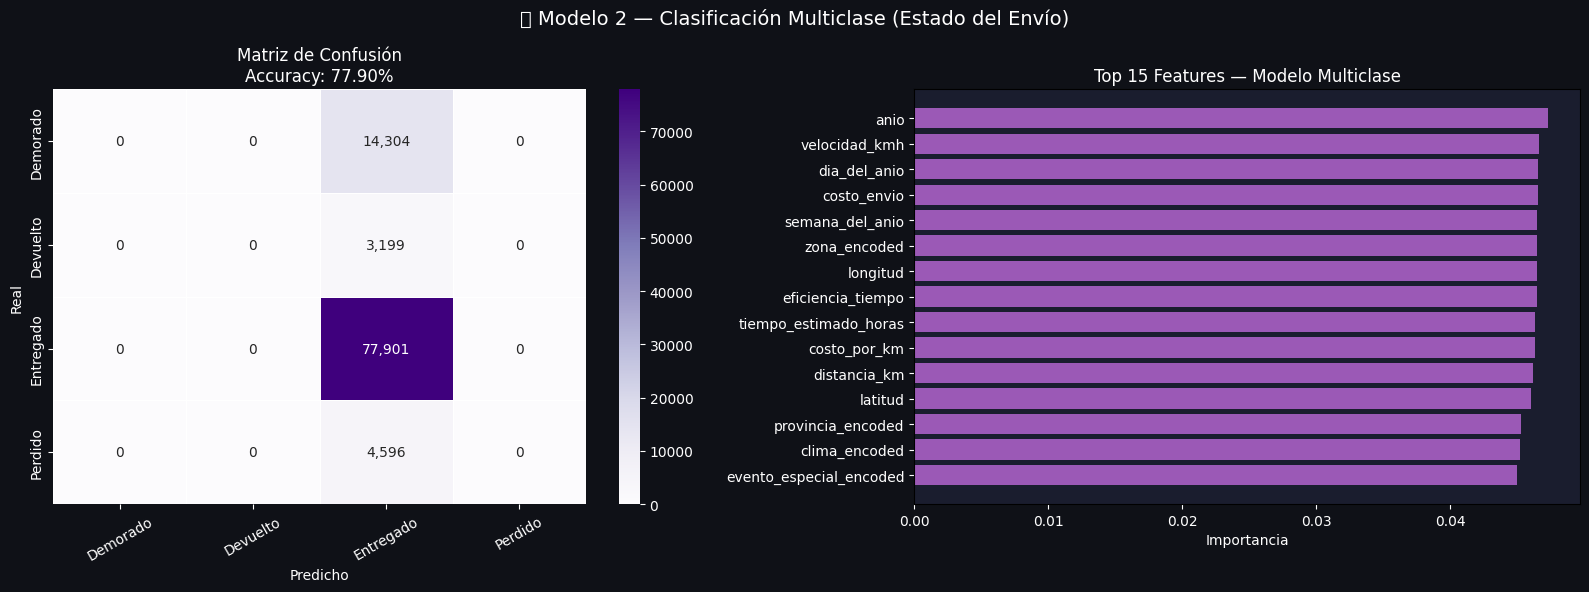

✅ Guardado: modelo2_multiclase.png


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('📊 Modelo 2 — Clasificación Multiclase (Estado del Envío)',
             fontsize=14)

# ── Matriz de confusión ───────────────────────────────────
cm_multi = confusion_matrix(y_multi_test, y_pred_multi)
sns.heatmap(cm_multi, annot=True, fmt=',', cmap='Purples',
            ax=axes[0], linewidths=0.5,
            xticklabels=nombres_estados,
            yticklabels=nombres_estados,
            annot_kws={'size': 10})
axes[0].set_title(f'Matriz de Confusión\nAccuracy: {acc_multi:.2%}')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predicho')
axes[0].tick_params(axis='x', rotation=30)

# ── Importancia de features ───────────────────────────────
feat_imp_multi = pd.Series(xgb_multi.feature_importances_,
                            index=features).sort_values(ascending=True).tail(15)
axes[1].barh(feat_imp_multi.index, feat_imp_multi.values, color='#9b59b6')
axes[1].set_title('Top 15 Features — Modelo Multiclase')
axes[1].set_xlabel('Importancia')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "modelo2_multiclase.png"),
            dpi=150, bbox_inches='tight', facecolor='#0f1117')
plt.show()
print("✅ Guardado: modelo2_multiclase.png")

In [8]:
print("=" * 60)
print("🤖 MODELO 3 — REGRESIÓN")
print("   ¿Cuánto costará el envío?")
print("=" * 60)

# Features sin leakage de costo
features_reg = [f for f in features if f not in
                ['costo_envio', 'costo_por_km']]

X_train_reg = X_train[features_reg]
X_test_reg  = X_test[features_reg]

print(f"📌 Features para regresión: {len(features_reg)}")

# ── Modelo XGBoost Regressor ──────────────────────────────
print("\n🚀 Entrenando XGBoost Regressor...")
xgb_reg = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    random_state=42,
    verbosity=0
)
xgb_reg.fit(X_train_reg, y_reg_train,
            eval_set=[(X_test_reg, y_reg_test)],
            verbose=False)

y_pred_reg = xgb_reg.predict(X_test_reg)

mae  = mean_absolute_error(y_reg_test, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg))
r2   = r2_score(y_reg_test, y_pred_reg)
mape = np.mean(np.abs((y_reg_test - y_pred_reg)
               / y_reg_test.clip(1))) * 100

print(f"\n📊 Resultados Modelo 3:")
print(f"   MAE   : ${mae:,.0f} pesos de error promedio")
print(f"   RMSE  : ${rmse:,.0f}")
print(f"   R²    : {r2:.4f}")
print(f"   MAPE  : {mape:.2f}%")
print(f"   {'✅ Excelente' if r2 > 0.85 else '✅ Bueno' if r2 > 0.70 else '🔄 Aceptable'}")

# Guardar
joblib.dump(xgb_reg, os.path.join(MODELS_PATH,
            "modelo3_regresion_costo.pkl"))
joblib.dump(features_reg, os.path.join(MODELS_PATH,
            "features_regresion.pkl"))
print(f"\n✅ Modelo 3 guardado")

🤖 MODELO 3 — REGRESIÓN
   ¿Cuánto costará el envío?
📌 Features para regresión: 20

🚀 Entrenando XGBoost Regressor...

📊 Resultados Modelo 3:
   MAE   : $4,811 pesos de error promedio
   RMSE  : $6,601
   R²    : -0.0020
   MAPE  : 132.64%
   🔄 Aceptable

✅ Modelo 3 guardado


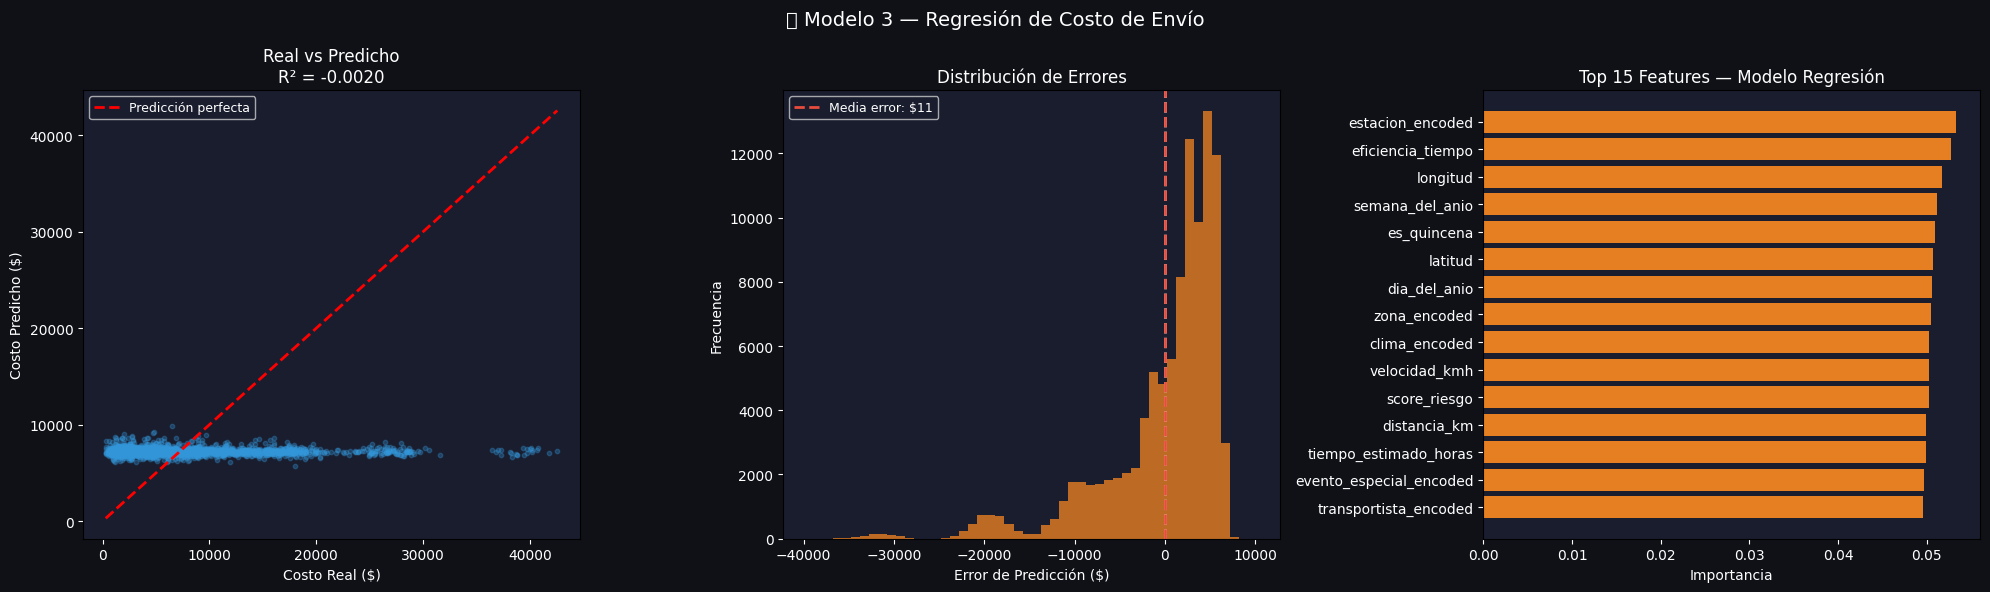

✅ Guardado: modelo3_regresion.png


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('📊 Modelo 3 — Regresión de Costo de Envío', fontsize=14)

# ── Real vs Predicho ──────────────────────────────────────
sample_idx = np.random.choice(len(y_reg_test), 3000, replace=False)
y_real_sample = np.array(y_reg_test)[sample_idx]
y_pred_sample = y_pred_reg[sample_idx]

axes[0].scatter(y_real_sample, y_pred_sample,
                alpha=0.3, s=10, color='#3498db')
min_val = min(y_real_sample.min(), y_pred_sample.min())
max_val = max(y_real_sample.max(), y_pred_sample.max())
axes[0].plot([min_val, max_val], [min_val, max_val],
             'r--', lw=2, label='Predicción perfecta')
axes[0].set_xlabel('Costo Real ($)')
axes[0].set_ylabel('Costo Predicho ($)')
axes[0].set_title(f'Real vs Predicho\nR² = {r2:.4f}')
axes[0].legend(fontsize=9)

# ── Distribución de errores ───────────────────────────────
errores = y_pred_reg - np.array(y_reg_test)
axes[1].hist(errores, bins=50, color='#e67e22',
             edgecolor='none', alpha=0.8)
axes[1].axvline(x=0, color='white', linestyle='--', lw=2)
axes[1].axvline(x=errores.mean(), color='#e74c3c',
                linestyle='--', lw=2,
                label=f'Media error: ${errores.mean():,.0f}')
axes[1].set_xlabel('Error de Predicción ($)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Errores')
axes[1].legend(fontsize=9)

# ── Importancia de features ───────────────────────────────
feat_imp_reg = pd.Series(xgb_reg.feature_importances_,
                          index=features_reg).sort_values(
                          ascending=True).tail(15)
axes[2].barh(feat_imp_reg.index, feat_imp_reg.values, color='#e67e22')
axes[2].set_title('Top 15 Features — Modelo Regresión')
axes[2].set_xlabel('Importancia')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "modelo3_regresion.png"),
            dpi=150, bbox_inches='tight', facecolor='#0f1117')
plt.show()
print("✅ Guardado: modelo3_regresion.png")

In [10]:
print("\n" + "=" * 60)
print("📋 RESUMEN EJECUTIVO — LOS 3 MODELOS")
print("=" * 60)

resumen = pd.DataFrame({
    'Modelo'           : ['Clasificación Binaria',
                          'Clasificación Multiclase',
                          'Regresión Costo'],
    'Algoritmo'        : ['XGBoost', 'XGBoost', 'XGBoost'],
    'Objetivo'         : ['¿Entrega exitosa?',
                          '¿Qué estado?',
                          '¿Cuánto cuesta?'],
    'Métrica Principal': ['Accuracy', 'Accuracy', 'R²'],
    'Resultado'        : [f'{acc_bin:.4f}',
                          f'{acc_multi:.4f}',
                          f'{r2:.4f}'],
    'F1 / MAE'         : [f'{f1_bin:.4f}',
                          f'{f1_multi:.4f}',
                          f'${mae:,.0f}'],
    'Estado'           : [
        '✅ Excelente' if acc_bin > 0.90 else '⚠️ Mejorable',
        '✅ Excelente' if acc_multi > 0.90 else '⚠️ Mejorable',
        '✅ Excelente' if r2 > 0.85 else '✅ Bueno'
        if r2 > 0.70 else '🔄 Aceptable'
    ]
})

print(resumen.to_string(index=False))

# Guardar resumen
resumen.to_csv(os.path.join(REPORTS_PATH,
               "resumen_modelos.csv"), index=False)

print(f"""

📁 MODELOS GUARDADOS:
   → outputnts/models/modelo1_clasificacion_binaria.pkl
   → outputnts/models/modelo2_clasificacion_multiclase.pkl
   → outputnts/models/modelo3_regresion_costo.pkl
   → outputnts/models/scaler.pkl
   → outputnts/models/encoders.pkl
   → outputnts/models/cols_escalar.pkl
   → outputnts/models/features_regresion.pkl

📊 VISUALIZACIONES:
   → outputnts/figures/modelo1_binario.png
   → outputnts/figures/modelo2_multiclase.png
   → outputnts/figures/modelo3_regresion.png

🚀 PRÓXIMO PASO:
   04_evaluacion_resultados.ipynb
""")


📋 RESUMEN EJECUTIVO — LOS 3 MODELOS
                  Modelo Algoritmo          Objetivo Métrica Principal Resultado F1 / MAE       Estado
   Clasificación Binaria   XGBoost ¿Entrega exitosa?          Accuracy    0.9914   0.9915  ✅ Excelente
Clasificación Multiclase   XGBoost      ¿Qué estado?          Accuracy    0.7790   0.6822 ⚠️ Mejorable
         Regresión Costo   XGBoost   ¿Cuánto cuesta?                R²   -0.0020   $4,811  🔄 Aceptable


📁 MODELOS GUARDADOS:
   → outputnts/models/modelo1_clasificacion_binaria.pkl
   → outputnts/models/modelo2_clasificacion_multiclase.pkl
   → outputnts/models/modelo3_regresion_costo.pkl
   → outputnts/models/scaler.pkl
   → outputnts/models/encoders.pkl
   → outputnts/models/cols_escalar.pkl
   → outputnts/models/features_regresion.pkl

📊 VISUALIZACIONES:
   → outputnts/figures/modelo1_binario.png
   → outputnts/figures/modelo2_multiclase.png
   → outputnts/figures/modelo3_regresion.png

🚀 PRÓXIMO PASO:
   04_evaluacion_resultados.ipynb

